In [3]:
import pywt.data
import scipy
import scipy.signal
import numpy as np
import pywt


import numpy as np
from scipy import signal
from scipy import misc
from skimage import io
from skimage import color
import matplotlib.pyplot as plt


def sum_of_neighbors(subband, neighbor_Size):
	kernel = np.ones((neighbor_Size, neighbor_Size))
	sum_of_neihbor = scipy.signal.correlate2d(subband, kernel, mode='same')
	return sum_of_neihbor

def elementwise_theshloding(matrix):
	matrix[matrix < 0] = 0
	return matrix

def elementwise_matrix_min(matrix):
	tmp = np.empty((len(matrix), matrix[0].shape[0], matrix[0].shape[1]))
	for i in range(len(matrix)):
		tmp[i] = matrix[i]
	min_mat = np.amin(tmp, axis=0)
	return min_mat

def denoised_subbands(hf_subband, est_min_sig, sigma_zero):
	den_h = np.multiply(hf_subband, ((est_min_sig) ** 2) / (((est_min_sig) ** 2) + ((sigma_zero) ** 2)))
	return den_h

def local_variance_original_noise_free_image(LH_h, HL_v, HH_d, sigma_0):
	W = [3, 5, 7, 9]
	sigma_est_H = []
	sigma_est_V = []
	sigma_est_D = []

	for w in W:
		sigma_est_H.append(elementwise_theshloding(sum_of_neighbors(1 / (w ** 2) * LH_h ** 2, w) - (sigma_0 ** 2)))
		sigma_est_V.append(elementwise_theshloding(sum_of_neighbors(1 / (w ** 2) * HL_v ** 2, w) - (sigma_0 ** 2)))
		sigma_est_D.append(elementwise_theshloding(sum_of_neighbors(1 / (w ** 2) * HH_d ** 2, w) - (sigma_0 ** 2)))

	min_sigma_est_D = elementwise_matrix_min(sigma_est_D)
	min_sigma_est_V = elementwise_matrix_min(sigma_est_V)
	min_sigma_est_H = elementwise_matrix_min(sigma_est_H)

	return min_sigma_est_H, min_sigma_est_V, min_sigma_est_D


def denoised_subbands(hf_subband, est_min_sig, sigma_zero):
	den_subband = np.multiply(hf_subband, (est_min_sig)) / ((est_min_sig) + ((sigma_zero) ** 2))
	return den_subband


def wavelet_filter(img):

	sigma_0 = 0.03
	wvt = pywt.wavedec2(img, 'db8', level=4)
	tup = wvt[1:]
	copy_wvt = wvt.copy()
	for i, (H, V, D) in enumerate(tup):
		min_sigma_est_h, min_sigma_est_v, min_sigma_est_d = local_variance_original_noise_free_image(H, V, D, sigma_0)
		den_sub_h = denoised_subbands(H, min_sigma_est_h, sigma_0)
		den_sub_v = denoised_subbands(V, min_sigma_est_v, sigma_0)
		den_sub_d = denoised_subbands(D, min_sigma_est_d, sigma_0)
		copy_wvt[i + 1] = (den_sub_h, den_sub_v, den_sub_d)

	den_img = pywt.waverec2(copy_wvt, 'db8', mode='symmetric', axes=(-2, -1))

	return den_img




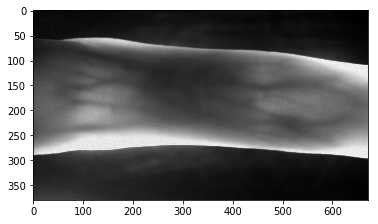

In [225]:


img=io.imread('img.png')
img= color.rgb2grey(img)
plt.imshow(img, cmap='gray')
plt.show()



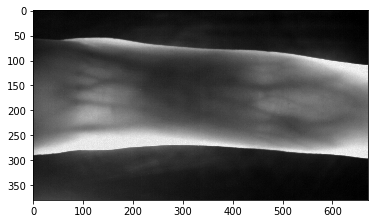

In [43]:
den_wav=wavelet_filter(img)
plt.imshow(den_wav, cmap='gray')
plt.show()

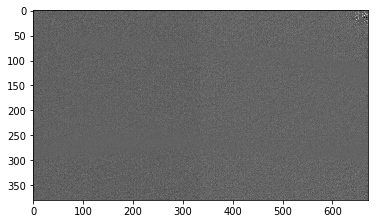

In [44]:
residual = img - den_wav
temp =np.copy(residual)
plt.imshow(temp, cmap='gray')
plt.show()



In [236]:
def zeroMean(temp):
    temp=residual
    row = temp.shape[0]
    col = temp.shape[1]
#     sliced = temp[1:row:2, 1:col:2]
    sliced = temp
    mu = np.mean(sliced)
    sliced_mu = sliced - mu
    rows = sliced_mu.shape[0]
    cols = sliced_mu.shape[1]
    row = sliced_mu.mean(axis=1, keepdims=True)
    column = sliced_mu.mean(axis=0, keepdims=True)
    Y = sliced_mu - row
    Y = Y - column
#     plt.imshow(Y, cmap='gray')
#     plt.show()
    return Y

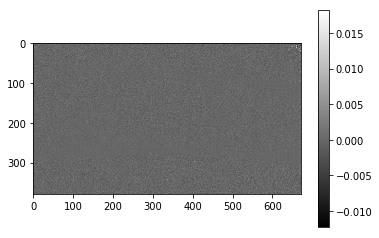

In [237]:
row = temp.shape[0]
col = temp.shape[1]

import matplotlib.cm as cm
Y=temp
# Y=
Z= zeroMean(temp[0::2,0::2])
Y[0::2,0::2] = Z[0::2,0::2]

Z = zeroMean(temp[0::2,1::2])
Y[0::2,1::2] = Z[0::2,1::2]

Z= zeroMean(temp[1::2,0::2])
Y[1::2,0::2] = Z[1::2,0::2]

Z = zeroMean(temp[1::2,1::2])
Y[1::2,1::2] = Z[1::2,1::2]
# Y = Y - residual
plt.imshow(Y, cmap=cm.gray)
plt.colorbar()
plt.show()



In [238]:
img=Y
type(Y)
print(Y)

[[ 8.98860620e-05  1.14846270e-03  1.93382858e-04 ... -2.31462542e-03
  -4.49779671e-03 -1.70934308e-03]
 [ 1.87348471e-03  2.39765271e-04  4.36201297e-04 ...  6.58147402e-03
   7.61389474e-03 -1.94612284e-03]
 [-1.39465319e-03  2.57590661e-04  4.91889326e-04 ... -1.72450070e-03
  -3.96869718e-03 -7.69428662e-04]
 ...
 [-1.39171707e-03  3.86835083e-04  4.25471775e-04 ... -2.19218241e-04
  -2.64001066e-03  1.53259240e-03]
 [ 1.02488033e-03  2.04743630e-04  7.34757092e-04 ...  2.37625152e-03
   3.20429195e-03 -5.44610466e-04]
 [ 1.78238159e-05 -4.29370003e-04 -8.45806462e-04 ... -1.77659535e-03
  -4.19382030e-04 -2.50503820e-04]]


In [247]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png
import numpy as np


# fn = get_sample_data("C:\\Users\\master\\Documents\\GitHub\\Computer-Vision-Playground\\ZeroMean\\img.png", asfileobj=False)
# img= color.rgb2grey(fn)
# img = read_png(img)

# x, y = np.mgrid[0:img.shape[0], 0:img.shape[1]]

# ax = plt.gca(projection='3d')
# ax.plot_surface(x, y, np.sin(0.02*x)*np.sin(0.02*y), rstride=2, cstride=2,
#                 facecolors=img)
# plt.show()


def plot_3d(matrix):
    x = []
    y = []
    z = []

    for (i,j), v in np.ndenumerate(matrix):
#         print((i,j), v)
        x.append(i)
        y.append(j)
        z.append(v)
        
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x,y,z, cmap=plt.cm.plasma, linewidth=0.2)
    ax.set_zlim3d(-0.015,0.015)
    plt.show()

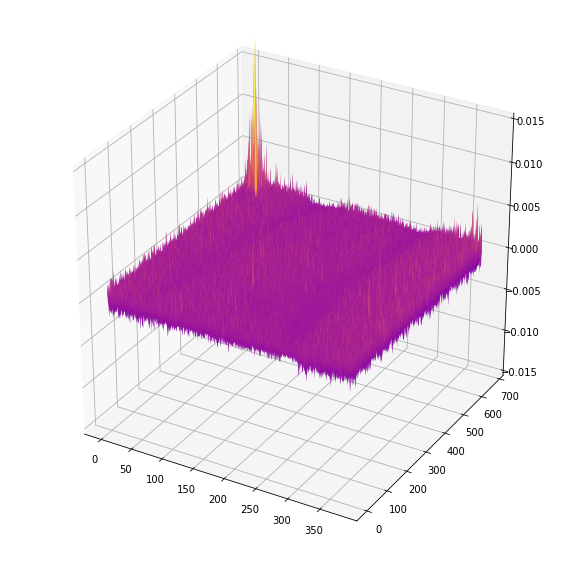

In [248]:
plot_3d(Y)